# Utilizing KNN Classification to Predict Whether or not a Patient with the Specified Parameters will have Heart Disease #

*DSCI 100: Group 22 Project Final Report*

**Introduction**

Cardiovascular disease (CVD), which encompasses all kinds of heart disease, remains the leading cause of death globally. Studies have shown that CVD “kills more people than all forms of cancer and respiratory diseases combined” (Reamy et al., 2018). Accurate diagnosis in the early stage is crucial to effectively treat and prevent possible heart disease. The question we ask is: Using a patient’s age, resting blood pressure, serum cholesterol level, and maximum heart rate achieved, how well can we predict the presence of heart disease using a K-nearest neighbors classifier? Our dataset is the Heart Failure Prediction dataset from Kaggle, which is a combination of five different datasets from the UCI Machine Learning Repository heart disease index, using 11 common features and one common label. These variables are *Age* for age in years, *Sex* for gender, *ChestPainType* for the type of angina, *RestingBP* for resting blood pressure, *Cholesterol* for serum cholesterol levels in blood, FastingBS for fasting blood sugar, *RestingECG* for resting electrocardiogram results, *MaxHR* for maximum heart rate achieved, *ExerciseAngina* for the angina is exercise-induced, *OldPeak* for ST depression induced by exercise relative to rest, *ST_Slope* for the slope of the peak exercise ST segment, and *HeartDisease* for the presence of heart disease.

**Methods & Results**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

We set the seed to make the code reproducible.

In [2]:
set.seed(3333)

Since downloading datasets from Kaggle requires an account, we have uploaded the dataset to a GitHub repository and have downloaded the .csv from the repository instead.

In [3]:
url <- "https://raw.githubusercontent.com/Stevan-Zhuang/DSCI-100-group-project-22/main/heart.csv"
    download.file(url, "heart-disease.csv")
heart <- read_csv("heart-disease.csv")
heart

Parsed with column specification:
cols(
  Age = col_double(),
  Sex = col_character(),
  ChestPainType = col_character(),
  RestingBP = col_double(),
  Cholesterol = col_double(),
  FastingBS = col_double(),
  RestingECG = col_character(),
  MaxHR = col_double(),
  ExerciseAngina = col_character(),
  Oldpeak = col_double(),
  ST_Slope = col_character(),
  HeartDisease = col_double()
)



Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


[Table 1]

The dataset contains general information for patients, as well as information related to the heart. There are 12 variables and 918 observations. The main categorical label that we want to predict is the *HeartDisease* column. *HeartDisease* can either be 0, meaning no heart disease, or 1, indicating the presence of heart disease.

We see that the dataframe *HeartDisease* is of type double. *HeartDisease* is a categorical variable, not a numerical one, so we convert it to a factor.

In [4]:
heart <- heart %>%
    mutate(HeartDisease = as_factor(HeartDisease))
heart

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


[Table 2]

Since we are using a KNN classifier, we can only use the numerical features. We select the columns with numerical data, which are *Age*, *RestingBP*, *Cholesterol* and *MaxHR*, along with the target variable (*HeartDisease*)

In [5]:
heart <- heart %>% 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)
heart

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
57,130,131,115,1
57,130,236,174,1
38,138,175,173,0


[Table 3]

We will need separate training and testing datasets to make sure the model is never trained on observations it is tested on. We do this by splitting our original dataset, with 80% of the observations going to the training dataset and 20% of the observations going to the testing dataset.

In [6]:
heart_split <- heart %>% initial_split(fold = 4/5, strata = HeartDisease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train
heart_test

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,160,180,156,1
37,130,283,98,0
48,138,214,108,1
⋮,⋮,⋮,⋮,⋮
45,110,264,132,1
68,144,193,141,1
57,130,131,115,1


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
54,150,195,122,0
54,110,208,142,0
⋮,⋮,⋮,⋮,⋮
57,140,241,123,1
57,130,236,174,1
38,138,175,173,0


[Table 4]

It would be helpful to see the distribution of the predicted variable to check if there are an equal amount of both possible values. If the distribution is unevenly split, we should take it into account when reviewing the metrics for our model.

In [7]:
heart_train %>%
    group_by(HeartDisease) %>%
    summarize(count = n())

`summarise()` ungrouping output (override with `.groups` argument)



HeartDisease,count
<fct>,<int>
0,308
1,381


[Table 5]

There are 308 observations of patients with heart disease, and 381 observations of patients without. The patients who have heart disease account for roughly 55% of all patients. This means there are more patients with heart disease than without in our dataset.

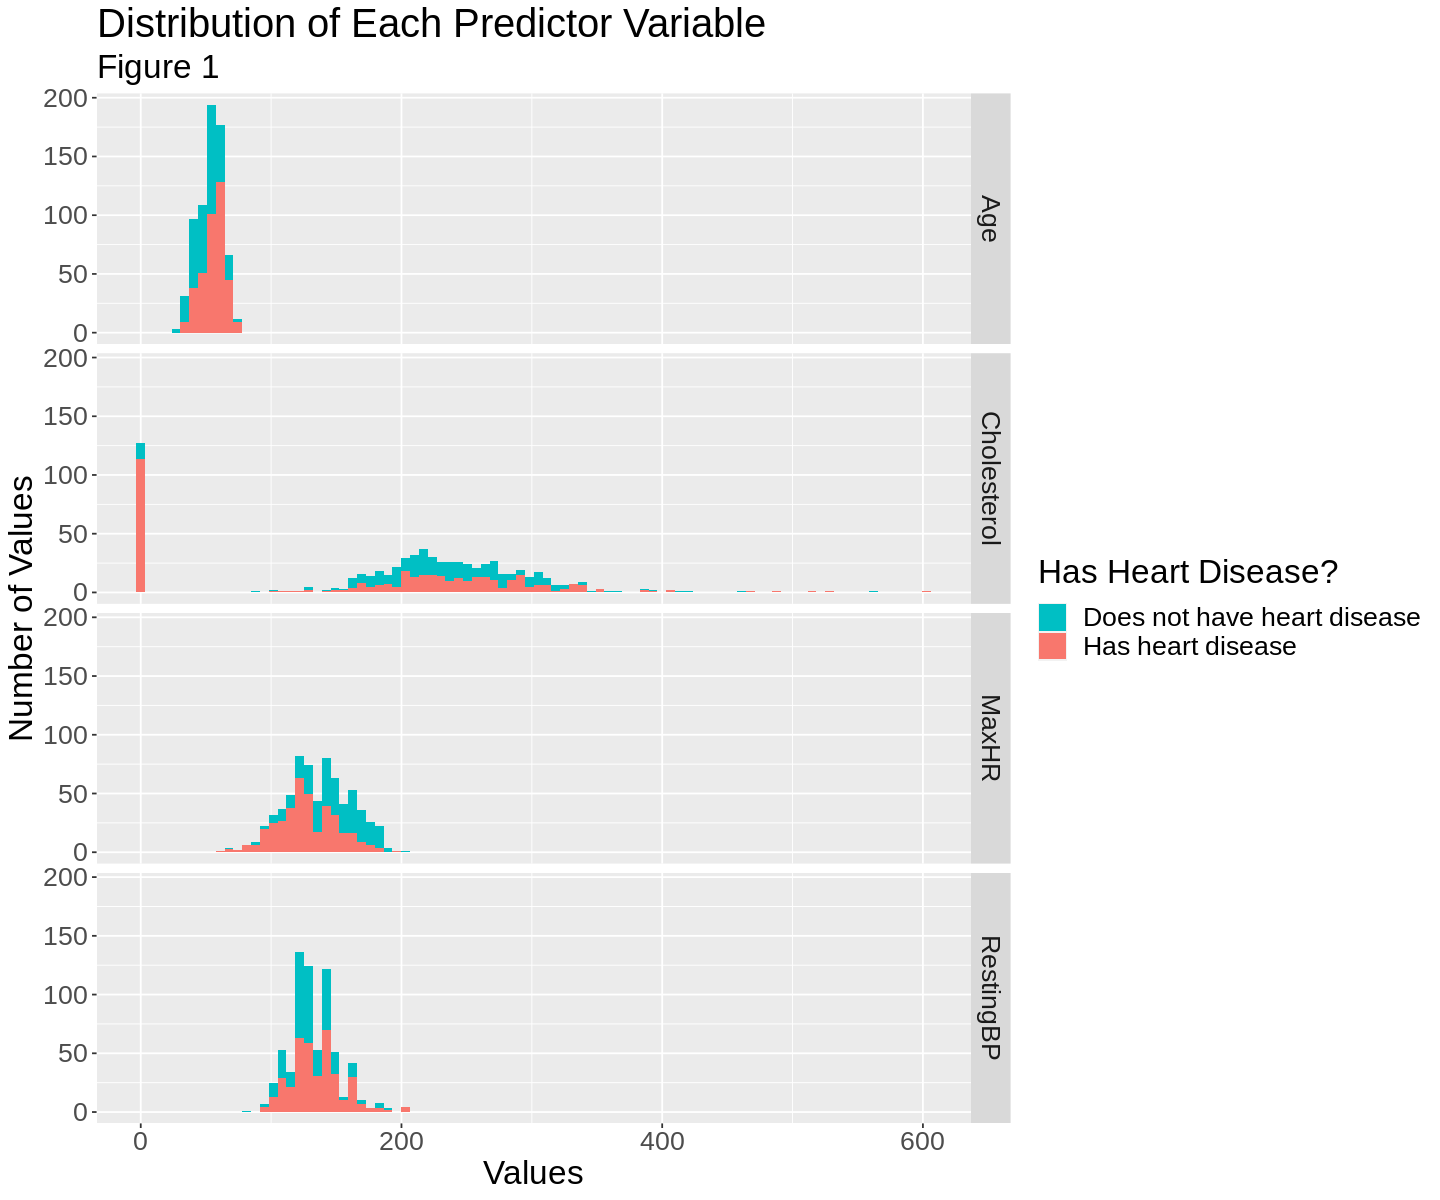

In [8]:
options(repr.plot.width = 12, repr.plot.height = 10)

heart_train %>%
    pivot_longer(Age:MaxHR, names_to = "column", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram(aes(fill = HeartDisease), bins = 90) +
    scale_fill_manual(labels = c("Does not have heart disease", "Has heart disease"),
                      values = c("#00BFC4", "#F8776D")) +
    facet_grid(column ~ .) +
    labs(x = "Values", y = "Number of Values",
         title = "Distribution of Each Predictor Variable",
         fill = "Has Heart Disease?",
         subtitle = "Figure 1") +
    theme(text = element_text(size = 20))

The plots above show the distribution of patients with/without heart disease for the predictor variables used. The distribution for *Cholesterol* is noticeably different from the other distributions and seems to contain a large amount of zero values. Since having a concentration of 0 mm/dl of cholesterol is unrealistic, it is likely a missing value and we should consider not using the *Cholesterol* variable or removing observations with *Cholesterol* values of 0.

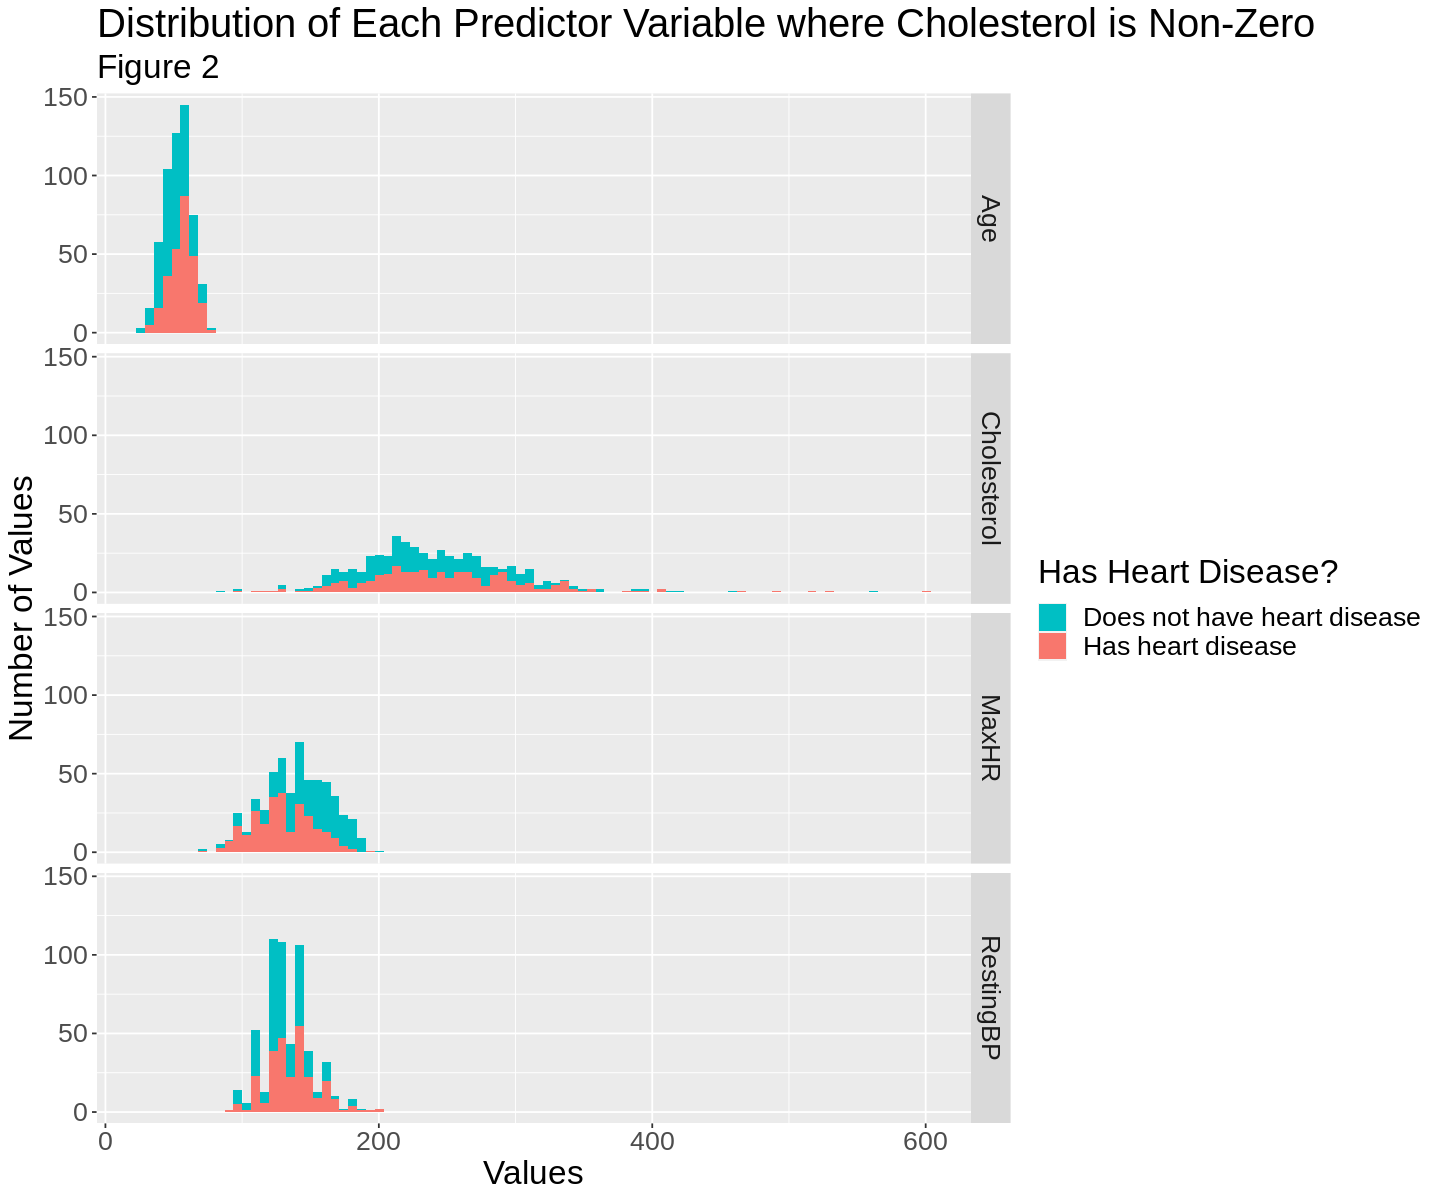

In [9]:
heart_train %>%
    filter(Cholesterol != 0) %>%
    pivot_longer(Age:MaxHR, names_to = "column", values_to = "value") %>%
    ggplot(aes(x = value)) +
    geom_histogram(aes(fill = HeartDisease), bins = 90) +
    scale_fill_manual(labels = c("Does not have heart disease", "Has heart disease"),
                      values = c("#00BFC4", "#F8776D")) +
    facet_grid(column ~ .) +
    labs(x = "Values", y = "Number of Values",
         title = "Distribution of Each Predictor Variable where Cholesterol is Non-Zero",
         fill = "Has Heart Disease?",
         subtitle = "Figure 2") +
    theme(text = element_text(size = 20))

Even with the zero values removed, the distribution for *Cholesterol* is noticeably more spread out than all of the other features. This tells us that scaling and centering the data will likely help the KNN classifier do better.

To create and train our KNN classifier, we will need to make a recipe, model and workflow. We start by making the recipe, predicting *HeartDisease* using other available variables along with scaling and centering the data.

In [10]:
heart_recipe <- recipe(HeartDisease ~ ., data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

To get more accurate metrics when training, we will use 5 fold cross validation (v = 5) to split our training dataset into five parts, averaging results while alternating each part as our validation set.

In [11]:
heart_cv <- heart_train %>%
    vfold_cv(v = 5, strata = HeartDisease)

Since we do not know the optimal value of k for our KNN classifier, we should test a range of k values to see what can get the best accuracy without underfitting or overfitting.

In [12]:
heart_knn <- nearest_neighbor(weight = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_knn

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Here we test our model on all odd k values from 1 to 50 and graph the results. We only test for odd values because an even value of neighbors can cause draws due to an equal amount of neighbors for each class.

In [13]:
gridvals = tibble(neighbors = seq(from = 1, to = 50, by = 2))

grid_metrics <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_knn) %>%
    tune_grid(resamples = heart_cv, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")
grid_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6561010,5,0.01552551,Model01
3,accuracy,binary,0.6749628,5,0.02199191,Model02
5,accuracy,binary,0.6937306,5,0.02107415,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,accuracy,binary,0.7140520,5,0.02929746,Model23
47,accuracy,binary,0.7096832,5,0.02616037,Model24
49,accuracy,binary,0.7140312,5,0.02675587,Model25


[Table 6]

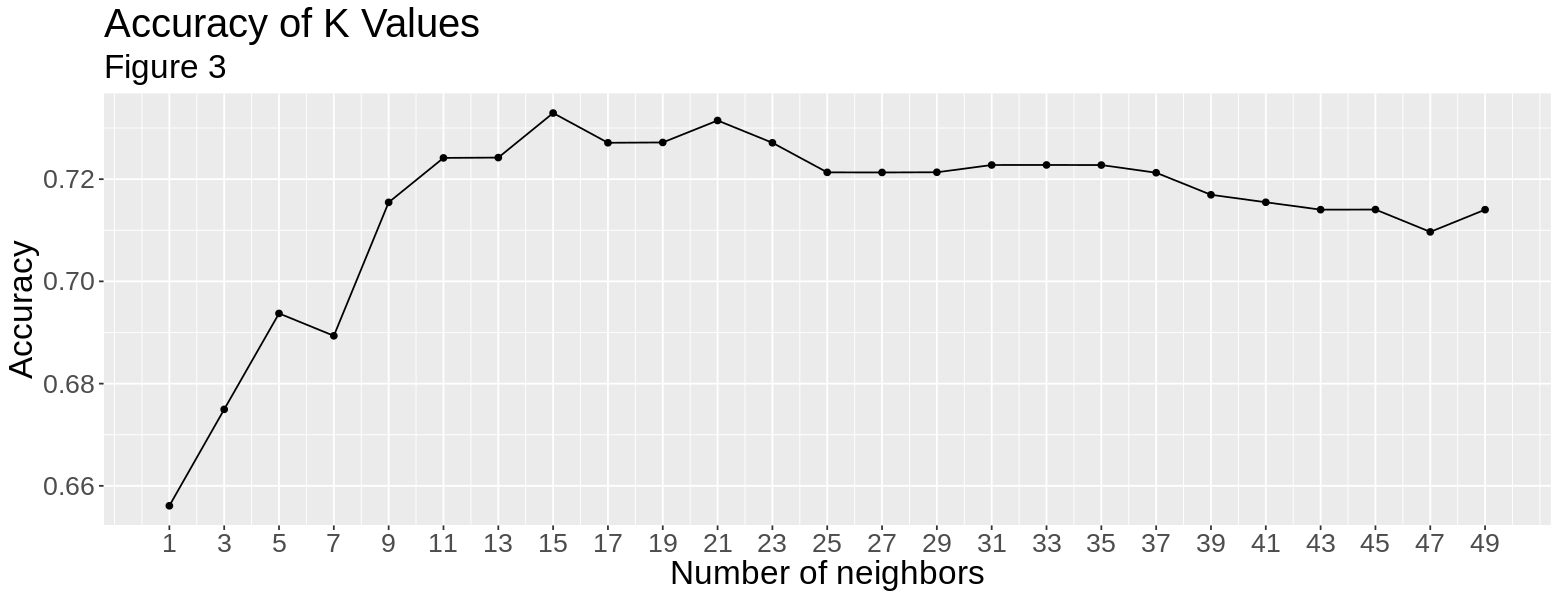

In [14]:
options(repr.plot.width = 13, repr.plot.height = 5)

accuracy_vs_k <- grid_metrics %>%
    ggplot(aes(neighbors, mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of neighbors", y = "Accuracy",
         title = "Accuracy of K Values",
         subtitle = "Figure 3") +
    scale_x_continuous(breaks = seq(from = 1, to = 50, by = 2)) +
    theme(text = element_text(size = 20))
accuracy_vs_k

From the plot above, the value for the number of neighbors that has the highest accuracy is 15, so we select it as our K value.

In [15]:
k_opt <- grid_metrics %>%
    arrange(desc(mean)) %>%
    select(neighbors) %>%
    slice(1) %>%
    pull()
k_opt

[1] 15

Now we train our model again using the optimal value of K we found earlier on the training dataset.

In [16]:
heart_knn_tuned <- nearest_neighbor(weight = "rectangular", neighbors = k_opt) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_knn_tuned

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = k_opt
  weight_func = rectangular

Computational engine: kknn 


In [17]:
heart_knn_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_knn_tuned) %>%
    fit(heart_train)
heart_knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_opt,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2670537
Best kernel: rectangular
Best k: 15

With our model trained, we have it predict on the training data and compare it with the actual labels for each observation to find the average accuracy of the model.

In [18]:
heart_knn_fit %>%
    predict(heart_train) %>%
    bind_cols(heart_train) %>%
    metrics(truth = HeartDisease, .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    slice(1) %>%
    pull()

[1] 0.7590711

The accuracy of our model on the training data is roughly 75%, meaning for every incorrect guess the model makes, it makes about three correct guesses. Since we trained our model on the training data itself, we should expect our model to have lower accuracy on the testing data.

In [19]:
heart_knn_fit %>%
    predict(heart_test) %>%
    bind_cols(heart_test) %>%
    metrics(truth = HeartDisease, .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    slice(1) %>%
    pull()

[1] 0.720524

We would like to visualize our model predictions, in order to interpret the effect of each predictor variable on the final result for the outcome variable. To do this, we plot our data as a scatter plot and colour the points by the presence of heart disease, and fill the background with a grid coloured by the prediction of the model at those points. However, since we have four predictor variables, there are too many dimensions to graph all at once. To get around this problem, we will graph our variables in pairs, and set the other variables to normal distributions with the same mean and standard deviation of those variables.

To create the grid of background values that our model will predict on, we use the meshgrid function from the pracma library. It is not installed by default, so we install it below.

In [20]:
install.packages("pracma")
library(pracma)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross




In order to make the visualization we talked about above, we will create ranges from the minimum values to the maximum values for the two variables we are graphing. Using these ranges and the meshgrid function, we will create a grid of values that the model will predict on. We repeat this step but shift the values to the left and right, so we can graph a boundary around each predicted point as a square. Finally, we find the mean and standard deviation of the remaining variables so we can create a normal distribution that approximates their original distribution.

In [21]:
step = 50

age_min <- heart_train %>% 
    summarize(m = min(Age)) %>% 
    pull()
age_max <- heart_train %>% 
    summarize(m = max(Age)) %>% 
    pull()
restingbp_min <- heart_train %>% 
    summarize(m = min(RestingBP)) %>% 
    pull()
restingbp_max <- heart_train %>% 
    summarize(m = max(RestingBP)) %>% 
    pull()

age_step <- (age_max - age_min) / step
restingbp_step <- (restingbp_max - restingbp_min) / step

age_range = seq(age_min, age_max, age_step)
restingbp_range = seq(restingbp_min, restingbp_max, restingbp_step)

age_restingbp_grid = meshgrid(age_range, restingbp_range)
age_vals = age_restingbp_grid[[1]]
restingbp_vals = age_restingbp_grid[[2]]

age_l_range = seq(age_min - age_step/2, age_max - age_step/2, age_step)
restingbp_l_range = seq(restingbp_min - restingbp_step/2,
                        restingbp_max - restingbp_step/2, restingbp_step)
age_restingbp_l_grid = meshgrid(age_l_range, restingbp_l_range)
age_l_vals = age_restingbp_l_grid[[1]]
restingbp_l_vals = age_restingbp_l_grid[[2]]

age_r_range = seq(age_min + age_step/2, age_max + age_step/2, age_step)
restingbp_r_range = seq(restingbp_min + restingbp_step/2,
                        restingbp_max + restingbp_step/2, restingbp_step)
age_restingbp_r_grid = meshgrid(age_r_range, restingbp_r_range)
age_r_vals = age_restingbp_r_grid[[1]]
restingbp_r_vals = age_restingbp_r_grid[[2]]

cholesterol_mean <- heart_train %>% 
    summarize(m = mean(Cholesterol)) %>% 
    pull()
cholesterol_sd <- heart_train %>% 
    summarize(sd = sd(Cholesterol)) %>% 
    pull()
maxhr_mean <- heart_train %>% 
    summarize(m = mean(MaxHR)) %>% 
    pull()
maxhr_sd <- heart_train %>% 
    summarize(sd = sd(MaxHR)) %>% 
    pull()

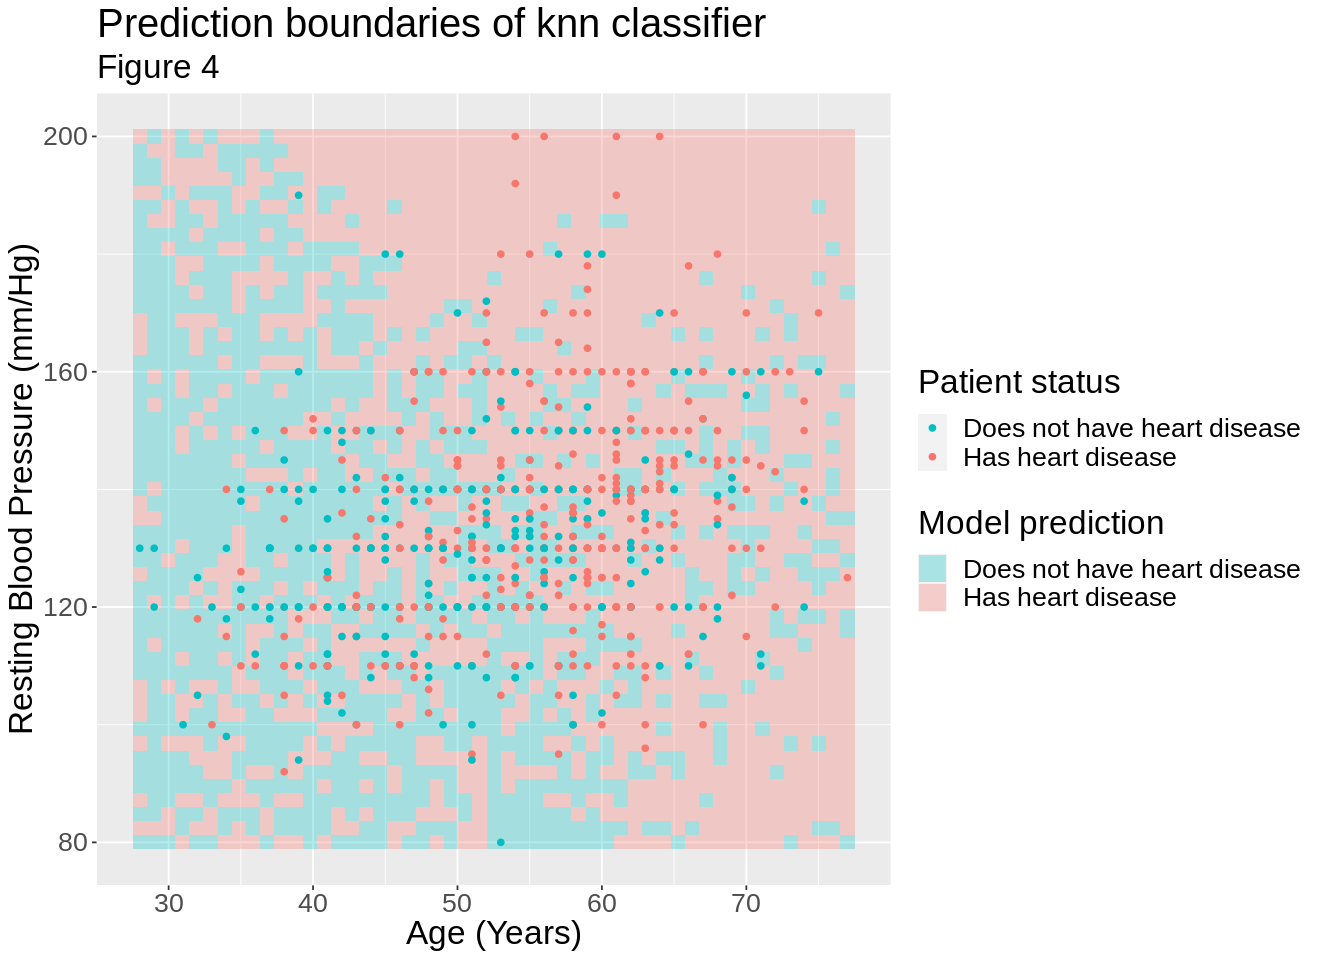

In [22]:
options(repr.plot.width = 11, repr.plot.height = 8)

grid <- tibble(age_l = c(age_l_vals),
               age_r = c(age_r_vals),
               restingbp_l = c(restingbp_l_vals),
               restingbp_r = c(restingbp_r_vals),
               Age = c(age_vals),
               RestingBP = c(restingbp_vals),
               Cholesterol = rnorm((step + 1)^2, mean = cholesterol_mean, sd = cholesterol_sd),
               MaxHR = rnorm((step + 1)^2, mean = maxhr_mean, sd = maxhr_sd))

grid_predictions <- heart_knn_fit %>%
    predict(grid) %>%
    bind_cols(grid)

ggplot() +
    geom_rect(data = grid_predictions,
              mapping = aes(xmin = age_l, xmax = age_r,
                            ymin = restingbp_l, ymax = restingbp_r,
                            fill = .pred_class),
              alpha = 0.3) +
    scale_fill_manual(labels = c("Does not have heart disease", "Has heart disease"),
                      values = c("#00BFC4", "#F8776D")) +
    geom_point(data = heart_train, mapping = aes(Age, RestingBP, color = HeartDisease)) +
    scale_color_manual(labels = c("Does not have heart disease", "Has heart disease"),
                       values = c("#00BFC4", "#F8776D")) +
    labs(x = "Age (Years)", y = "Resting Blood Pressure (mm/Hg)",
         title = "Prediction boundaries of knn classifier",
         color = "Patient status", fill = "Model prediction",
         subtitle = "Figure 4") +
    theme(text = element_text(size = 20))

We repeat this process but with the variable pairs switched around.

In [23]:
cholesterol_min <- heart_train %>% summarize(m = min(Cholesterol)) %>% pull()
cholesterol_max <- heart_train %>% summarize(m = max(Cholesterol)) %>% pull()
maxhr_min <- heart_train %>% summarize(m = min(MaxHR)) %>% pull()
maxhr_max <- heart_train %>% summarize(m = max(MaxHR)) %>% pull()

cholesterol_step <- (cholesterol_max - cholesterol_min) / step
maxhr_step <- (maxhr_max - maxhr_min) / step

cholesterol_range = seq(cholesterol_min, cholesterol_max, cholesterol_step)
maxhr_range = seq(maxhr_min, maxhr_max, maxhr_step)

cholesterol_maxhr_grid = meshgrid(cholesterol_range, maxhr_range)
cholesterol_vals = cholesterol_maxhr_grid[[1]]
maxhr_vals = cholesterol_maxhr_grid[[2]]

cholesterol_l_range = seq(cholesterol_min - cholesterol_step/2,
                          cholesterol_max - cholesterol_step/2, cholesterol_step)
maxhr_l_range = seq(maxhr_min - maxhr_step/2,
                    maxhr_max - maxhr_step/2, maxhr_step)

cholesterol_maxhr_l_grid = meshgrid(cholesterol_l_range, maxhr_l_range)
cholesterol_l_vals = cholesterol_maxhr_l_grid[[1]]
maxhr_l_vals = cholesterol_maxhr_l_grid[[2]]

cholesterol_r_range = seq(cholesterol_min + cholesterol_step/2,
                          cholesterol_max + cholesterol_step/2, cholesterol_step)
maxhr_r_range = seq(maxhr_min + maxhr_step/2,
                    maxhr_max + maxhr_step/2, maxhr_step)
cholesterol_maxhr_r_grid = meshgrid(cholesterol_r_range, maxhr_r_range)
cholesterol_r_vals = cholesterol_maxhr_r_grid[[1]]
maxhr_r_vals = cholesterol_maxhr_r_grid[[2]]

age_mean <- heart_train %>% summarize(m = mean(Age)) %>% pull()
age_sd <- heart_train %>% summarize(sd = sd(Age)) %>% pull()
restingbp_mean <- heart_train %>% summarize(m = mean(RestingBP)) %>% pull()
restingbp_sd <- heart_train %>% summarize(sd = sd(RestingBP)) %>% pull()

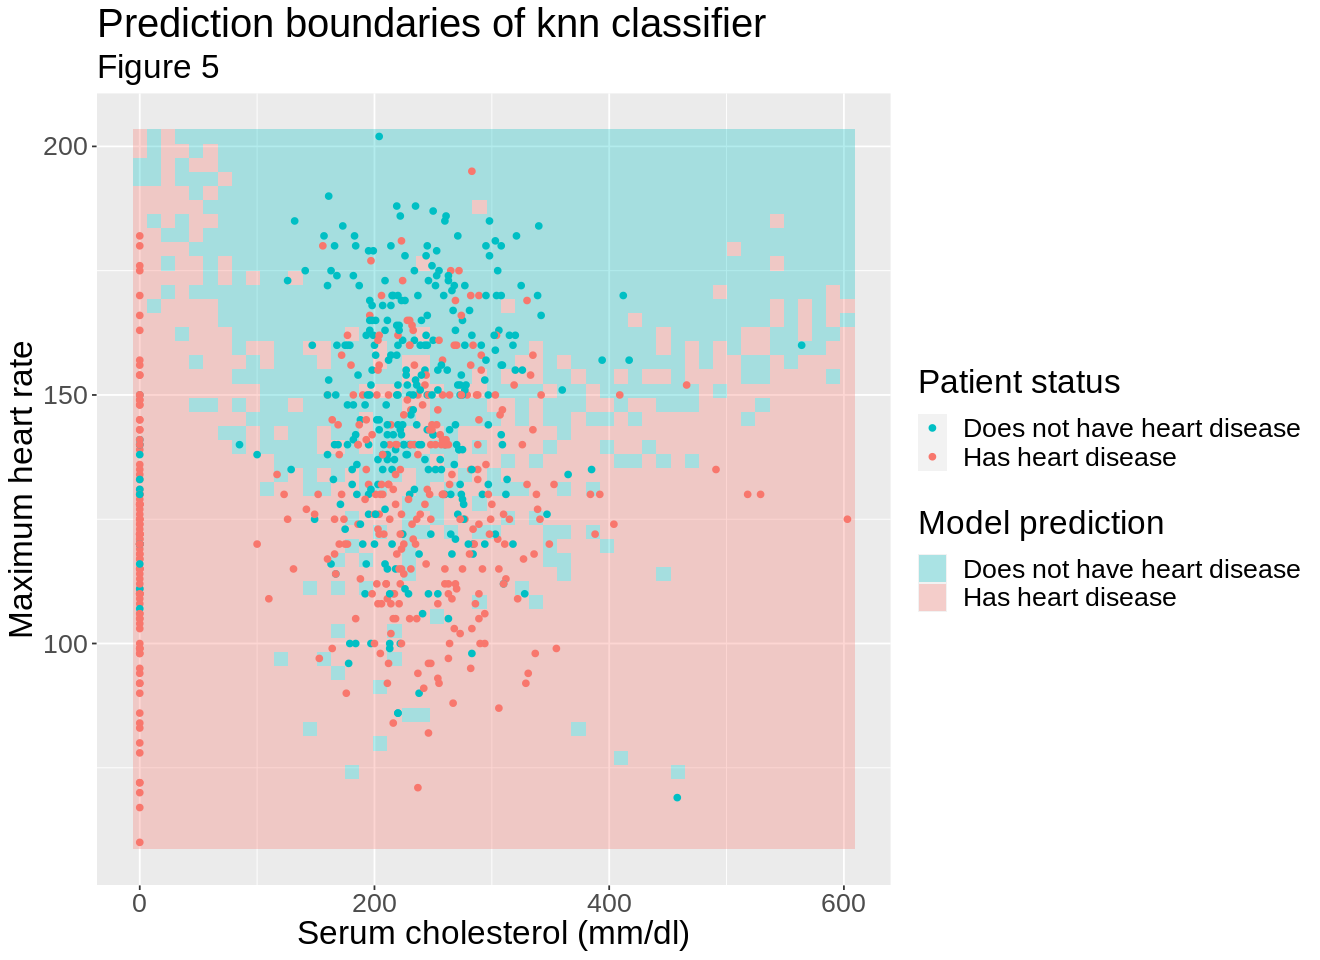

In [24]:
options(repr.plot.width = 11, repr.plot.height = 8)

grid <- tibble(cholesterol_l = c(cholesterol_l_vals),
               cholesterol_r = c(cholesterol_r_vals),
               maxhr_l = c(maxhr_l_vals),
               maxhr_r = c(maxhr_r_vals),
               Cholesterol = c(cholesterol_vals),
               MaxHR = c(maxhr_vals),
               Age = rnorm((step + 1)^2, mean = age_mean, sd = age_sd),
               RestingBP = rnorm((step + 1)^2, mean = restingbp_mean, sd = restingbp_sd))

grid_predictions <- heart_knn_fit %>%
    predict(grid) %>%
    bind_cols(grid)

ggplot() +
    geom_rect(data = grid_predictions,
              mapping = aes(xmin = cholesterol_l, xmax = cholesterol_r,
                            ymin = maxhr_l, ymax = maxhr_r,
                            fill = .pred_class),
              alpha = 0.3) +
    scale_fill_manual(labels = c("Does not have heart disease", "Has heart disease"),
                      values = c("#00BFC4", "#F8776D")) +
    geom_point(data = heart_train, mapping = aes(Cholesterol, MaxHR, color = HeartDisease)) +
    scale_color_manual(labels = c("Does not have heart disease", "Has heart disease"),
                       values = c("#00BFC4", "#F8776D")) +
    labs(x = "Serum cholesterol (mm/dl)", y = "Maximum heart rate",
         title = "Prediction boundaries of knn classifier",
         color = "Patient status", fill = "Model prediction",
         subtitle = "Figure 5") +
    theme(text = element_text(size = 20))

In [25]:
heart_knn_fit %>%
    predict(heart_test) %>%
    bind_cols(heart_test) %>%
    metrics(truth = HeartDisease, .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    slice(1) %>%
    pull()

[1] 0.720524

As expected, the accuracy of the model on the testing set is lower than the accuracy of the training set, sitting at roughly 72%.

**Discussion**

According to the visualizations of the 4 variables, our findings regarding whether there are positive relationships between Age, RestingBP, Cholesterol, MaxHR and the presence of heart disease are as follows: As the values of Age, RestingBP and Cholesterol increase, the patient is more likely to have heart disease. As the value of MaxHR increases, the patient is less likely to have heart disease. In other words, the relationship between Age, RestingBP and Cholesterol values and the probability of having heart disease is positive, while the correlation between MaxHR and the probability of having heart disease is negative.

Based on the findings, we see that the relationships between Age, RestingBP, Cholesterol and the existence of heart disease meet our expectations. Only the result of MaxHR contradicts with what we expect to find. 

Since manually determining the presence of heart disease is difficult, this data can be used to detect the existence of cardiovascular disease early on and treat it before it is too late. With this information, people might be more inclined to work harder to reduce cholesterol levels, keep blood pressure under control and maintain a healthy lifestyle. Thus, this may help decrease the mortality rate from heart disease around the world. Future questions this could lead to include how could we improve our classification method as well as integrate these classification techniques into the diagnosis process in our healthcare system?

**References**

Gaye, B., Tajeu, G. S., Vasan, R. S. et al. (2020). Association of Changes in Cardiovascular Health Metrics and Risk of Subsequent Cardiovascular Disease and Mortality. Journal of the American Heart Association, 9(19). https://doi.org/10.1161/JAHA.120.017458

Michos, E. D., & Khan, S. S. (2021). Further understanding of ideal cardiovascular health score metrics and cardiovascular disease. Expert Review of Cardiovascular Therapy, 19(7), 607-617. https://doi.org/10.1080/14779072.2021.1937127

Reamy, B. V., Williams, P. M., & Kuckel, D. P. (2018). Prevention of Cardiovascular Disease. Primary care, 45(1), 25-44. https://doi.org/10.1016/j.pop.2017.11.003